In [6]:
import random
import torch
import torch.optim as optim
import torch.nn as nn
from typing import List, Tuple, Union
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
import math
import torch.nn.functional as F
from collections import namedtuple


class ConnectFourEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    rewards = {
        'win': 1000,
        'draw': 500,
        'nothing': -10,
        'invalid': -1000,
    }

    def __init__(self):
        super(ConnectFourEnv, self).__init__()
        self.rows = 6
        self.columns = 7
        self.in_a_row = 4
        self.action_space = spaces.Discrete(self.columns)
        self.observation_space = spaces.Box(
            low=0, high=2, shape=(self.rows, self.columns), dtype=int)
        self.winner = 0
        self.reset()

    def flip_board(self):
        self.board = [[3 - x if x != 0 else 0 for x in row]
                      for row in self.board]

    def step(self, action):
        # Check if action is valid
        if self.playable_rows[action] == -1:
            self.winner = 3 - self.current_player
            return self.board, self.rewards['invalid'], True, {}

        if self.done:
            raise ValueError("Game is over, please reset the environment")

        # Find the next open row
        playable_row = self.playable_rows[action]
        self.board[playable_row][action] = self.current_player
        self.playable_rows[action] -= 1

        reward, self.done = self.check_win(playable_row, action)
        self.current_player = 3 - self.current_player  # Switch player
        return self.board, reward, self.done, {}

    def reset(self):
        self.board = [[0] * self.columns for _ in range(self.rows)]
        self.playable_rows = [self.rows - 1] * self.columns
        self.winner = 0
        self.current_player = 1
        self.done = False
        return self.board

    def render(self, mode='human'):
        fig, ax = plt.subplots()
        # Draw the board
        for x in range(self.columns):
            for y in range(self.rows):
                circle = patches.Circle(
                    (x, self.rows - y - 1), 0.45, fill=False, color='black', lw=2)
                if self.board[y][x] == 1:
                    circle = patches.Circle(
                        (x, self.rows - y - 1), 0.45, fill=True, color='red', lw=2)
                elif self.board[y][x] == 2:
                    circle = patches.Circle(
                        (x, self.rows - y - 1), 0.45, fill=True, color='yellow', lw=2)
                ax.add_patch(circle)
        plt.xlim(-0.5, self.columns-0.5)
        plt.ylim(-0.5, self.rows-0.5)
        ax.set_aspect('equal')
        plt.grid()
        plt.xticks(range(self.columns))
        plt.yticks(range(self.rows))
        plt.show()

    def check_win(self, row, col):
        # Check only from the last move's position
        # Horizontal, vertical, diagonal down, diagonal up
        directions = [(0, 1), (1, 0), (1, 1), (1, -1)]
        for dx, dy in directions:
            count = 1  # Count includes the last move
            # Check in the positive direction
            for i in range(1, 4):
                x, y = row + dx*i, col + dy*i
                if x < 0 or x >= self.rows or y < 0 or y >= self.columns or self.board[x][y] != self.current_player:
                    break
                count += 1
            # Check in the negative direction
            for i in range(1, 4):
                x, y = row - dx*i, col - dy*i
                if x < 0 or x >= self.rows or y < 0 or y >= self.columns or self.board[x][y] != self.current_player:
                    break
                count += 1
            if count >= self.in_a_row:
                self.winner = self.current_player
                return self.rewards['win'], True
            

        # Check for draw
        if all([x == self.rows for x in self.playable_rows]):
            self.winner = 3 - self.current_player
            return self.rewards['draw'], True
        return self.rewards['nothing'], False
    
    def play(self, agent1, agent2, n_games=1000, show_game=False, show_outcome=False):
        # Play n games between two agents
        results = {1: 0, 2: 0}
        game_lengths = []
        for _ in range(n_games):
            self.reset()
            done = False
            while not done:
                if show_game:
                    self.render()

                action = agent1.choose_action()
                _, reward, done, _ = self.step(action)
                if done:
                    break

                if show_game:
                    self.render()
                    
                action = agent2.choose_action()
                _, reward, done, _ = self.step(action)

            results[self.winner] += 1
            game_lengths.append(self.rows * (self.columns - 1) - sum(self.playable_rows))
            
            if show_outcome or show_game:
                self.render()

        avg_game_length = sum(game_lengths) / len(game_lengths)
        return results, avg_game_length

    
class Agent:
    def __init__(self, env):
        pass

    def choose_action(self):
        pass


class RandomAgent(Agent):
    def __init__(self, env):
        self.env = env
        self.name = "RandomAgent"
        

    def choose_action(self):
        # play any legal move
        return random.choice([i for i in range(self.env.columns) if self.env.playable_rows[i] >= 0])

In [2]:
Transition = namedtuple(
    'Transition', ('state', 'action', 'reward', 'next_state', 'done'))


class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape[0] * input_shape[1], 42),
            nn.ReLU(),
            nn.Linear(42, 24),
            nn.ReLU(),
            nn.Linear(24, num_actions)
        )

    def forward(self, x):
        return self.net(x)


class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer: List[Transition] = []
        self.position = 0

    def push(self, state: torch.Tensor, action: int, reward, next_state: torch.Tensor, done):
        action_tensor = torch.tensor(
            [action], dtype=torch.long)  # Wrap action as a tensor
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = Transition(
            state, action_tensor, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        # batched sampling
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)


Transition = namedtuple(
    'Transition', ('state', 'action', 'reward', 'next_state', 'done'))


class DQNAgent(Agent):
    def __init__(self, env, replay_buffer, evaluation_agent=None):
        self.env = env
        self.name = "DQNAgent"
        self.state_dim = env.observation_space.shape
        self.action_dim = env.action_space.n
        self.replay_buffer: ReplayBuffer = replay_buffer
        self.policy_net = DQN(self.state_dim, self.action_dim)
        self.target_net = DQN(self.state_dim, self.action_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()  # Target net is not trained
        self.lr = 0.005
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)
        self.steps_done = 0
        self.epsilon_start = 1.0
        self.epsilon_end = 0.15 # if you leave overnight, you can decrease this to 0.01
        self.epsilon_decay = 500_000 # if you leave overnight, you can increase this to 1_000_000
        self.batch_size = 256
        self.gamma = 1  # Discount factor
        self.target_update = 1000
        if evaluation_agent is None:
            self.evaluation_agent = RandomAgent(self.env)
        else:
            self.evaluation_agent = evaluation_agent

    def load_trained_model_from_file(self, path):
        self.policy_net = torch.load(path)
        self.policy_net.eval()

    def choose_action(self, explore=False) -> int:
        sample = random.random()
        epsilon_threshold = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
            math.exp(-1. * self.steps_done / self.epsilon_decay)
        if sample > epsilon_threshold or not explore:
            with torch.no_grad():
                state = torch.tensor(
                    self.env.board, dtype=torch.float).unsqueeze(0)
                decision = self.policy_net(state)
                return decision.max(1)[1].view(1, 1).item()
        else:
            return random.randrange(self.action_dim)

    def optimize_model(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        # Sample a batch of experiences from the replay buffer
        transitions = self.replay_buffer.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        # Separate the components of each transition
        batch_states = torch.stack(batch.state).float()
        batch_actions = torch.stack(batch.action).view(-1, 1).long()
        batch_rewards = torch.tensor(batch.reward, dtype=torch.float)
        batch_next_states = torch.stack(batch.next_state).float()
        batch_dones = torch.tensor(batch.done, dtype=torch.float)

        # Calculate current Q-values from the policy_net
        current_q_values = self.policy_net(batch_states).gather(
            1, batch_actions).squeeze(1)

        # Calculate the maximum Q-value for the next states from the target_net
        next_state_values = self.target_net(
            batch_next_states).max(1)[0].detach()
        

        # Apply (1 - done) to zero out the values for terminal states
        next_state_values = next_state_values * (1 - batch_dones)

        # Compute the expected Q values for the current state-action pairs
        expected_q_values = batch_rewards + self.gamma * next_state_values

        # Compute loss
        loss = F.smooth_l1_loss(current_q_values, expected_q_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self, n_games, print_interval):
        losses = []

        self.evaluate(50, message=True)

        for episode in tqdm(range(n_games)):
            observation = self.env.reset()
            observation = torch.tensor(observation, dtype=torch.float)
            done = False

            while not done:
                action = self.choose_action(explore=True)
                self.steps_done += 1

                next_observation, reward, done, info = self.env.step(action)
                
                # the agent thinks he is player 1, so we need to flip the board and the player
                self.env.flip_board()
                self.env.current_player = 3 - self.env.current_player
                
                next_observation = torch.tensor(
                    next_observation, dtype=torch.float)

                reward = torch.tensor([reward], dtype=torch.float)
                done_tensor = torch.tensor([done], dtype=torch.float)

                self.replay_buffer.push(
                    observation, action, reward, next_observation, done_tensor)
                observation = next_observation

                loss = self.optimize_model()

                if loss is not None:
                    losses.append(loss)

            if (episode + 1) % self.target_update == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            if (episode + 1) % print_interval == 0 and len(losses) > 0:
                avg_loss = sum(losses[-print_interval:]) / len(losses[-print_interval:])
                print(f"Episode {episode + 1}: Average Loss = {avg_loss}")
                self.evaluate(50, message=True)
                self.evaluate(50, message=True, evaluation_agent=RandomAgent(self.env))
                print()
                torch.save(self.policy_net, f"checkpoints/model_{episode + 1}.pt")
               

    def evaluate(self, n_games, show=False, message=False, evaluation_agent=None):
        if evaluation_agent is None:
            evaluation_agent = self.evaluation_agent

        wins, avg_length = self.env.play(self, evaluation_agent, n_games, show)
        if message:
            print(f"Out of {n_games} games against {evaluation_agent.name}, the model won {wins[1]} games : {wins[1] / n_games * 100:.2f}% with an average game length of {avg_length}")
        return wins

In [7]:
# Train a new model
env = ConnectFourEnv()
replay_buffer = ReplayBuffer(10000)
agent = DQNAgent(env, replay_buffer)
# agent.load_trained_model_from_file("checkpoints/model_6000.pt")
agent.evaluation_agent = agent

In [4]:
agent.train(1_000_000, print_interval=1000)

Out of 50 games against DQNAgent, the model won 0 games : 0.00% with an average game length of 6.0


  0%|          | 88/1000000 [00:01<5:36:22, 49.54it/s] 


KeyboardInterrupt: 

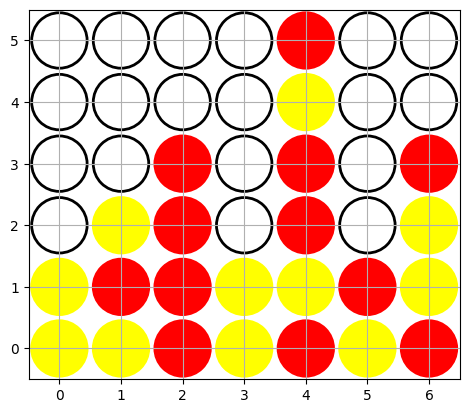

({1: 1, 2: 0}, 24.0)

In [11]:
env.play(RandomAgent(env), RandomAgent(env), n_games=1, show_outcome=True)

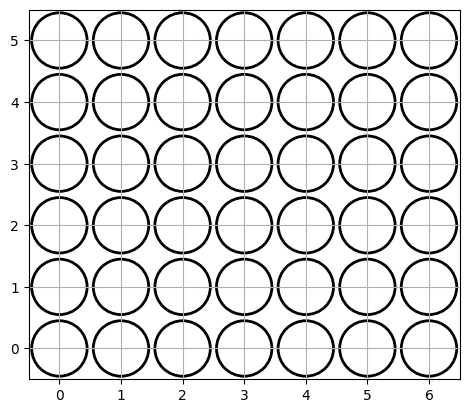

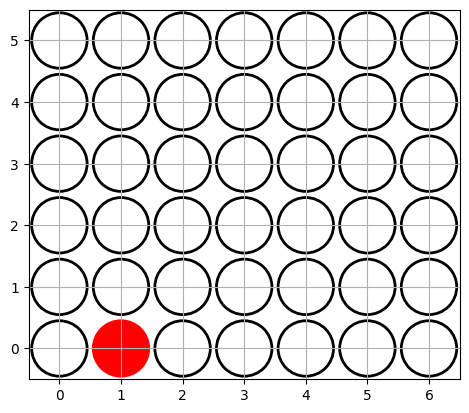

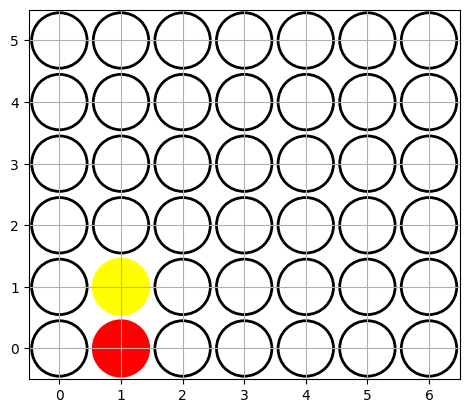

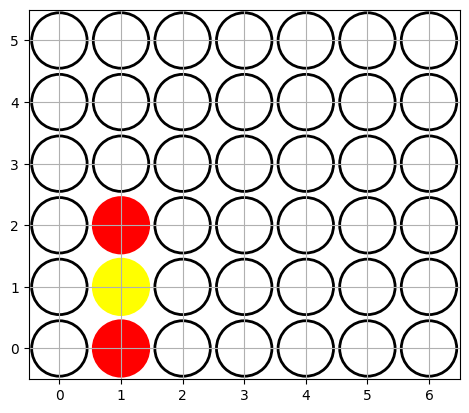

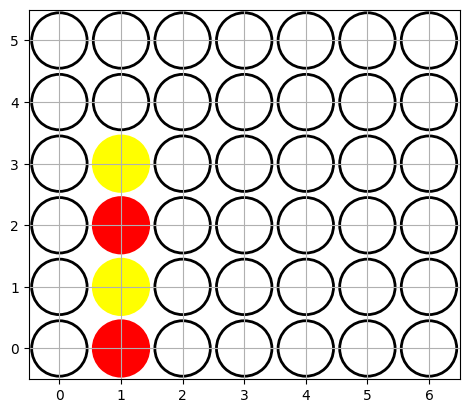

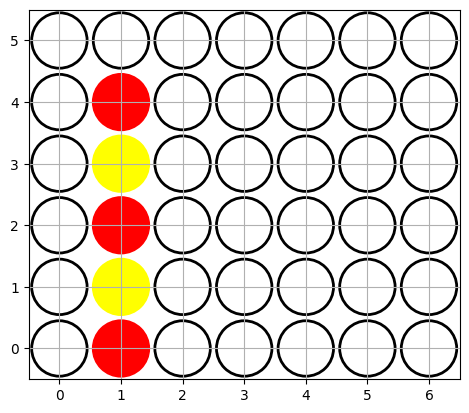

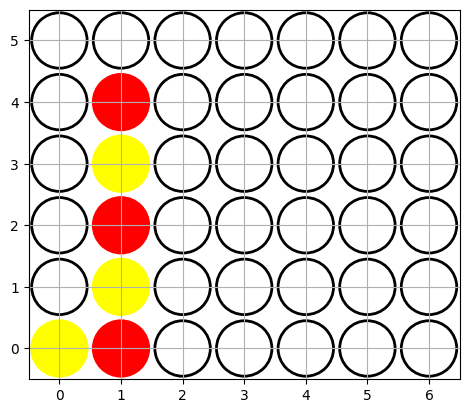

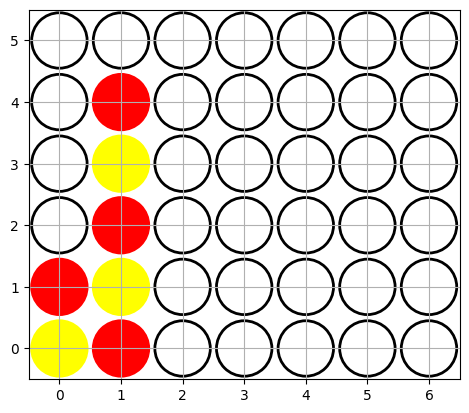

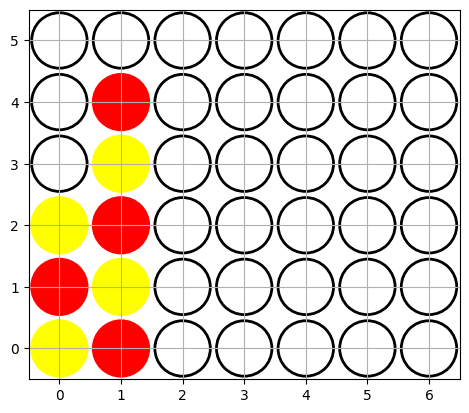

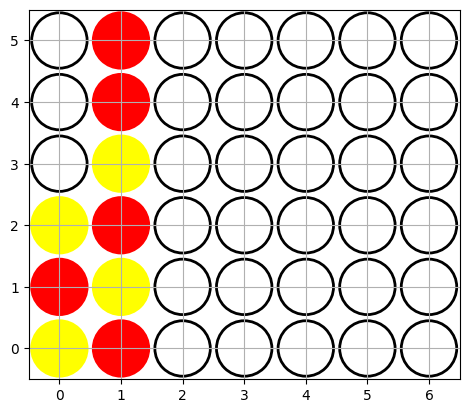

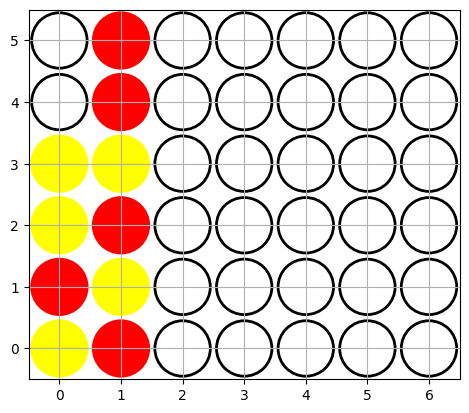

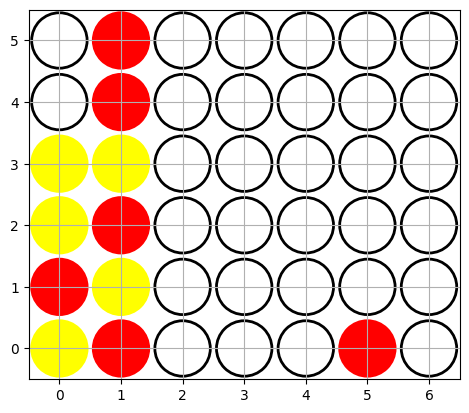

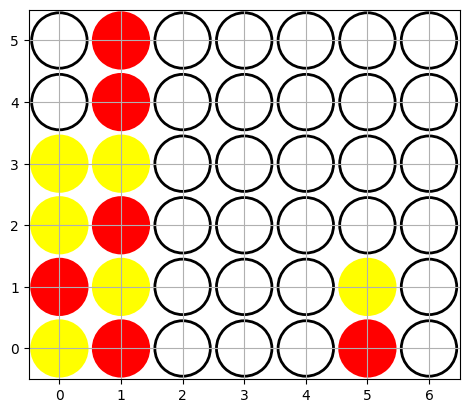

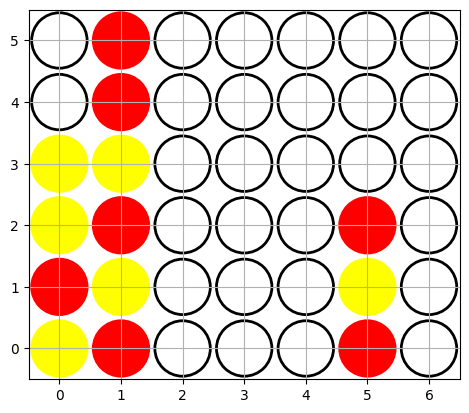

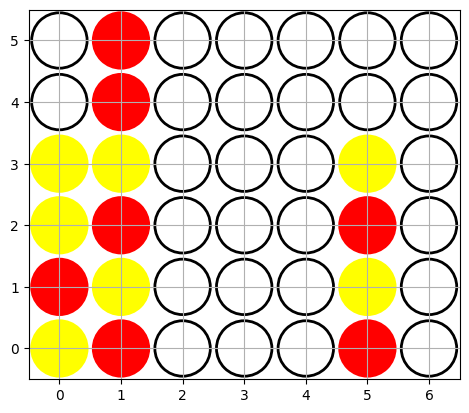

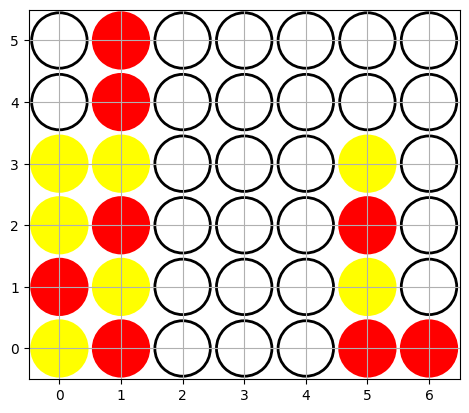

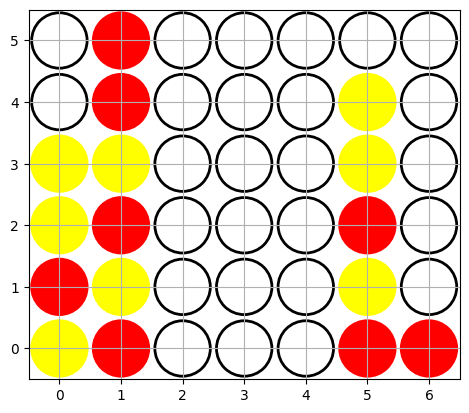

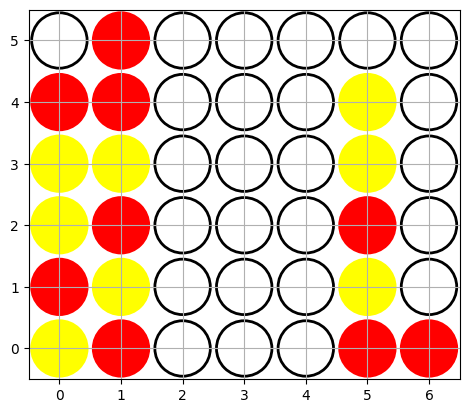

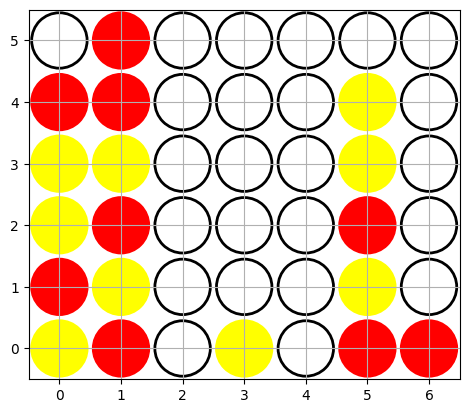

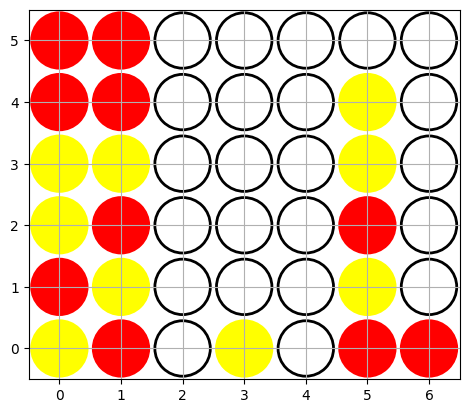

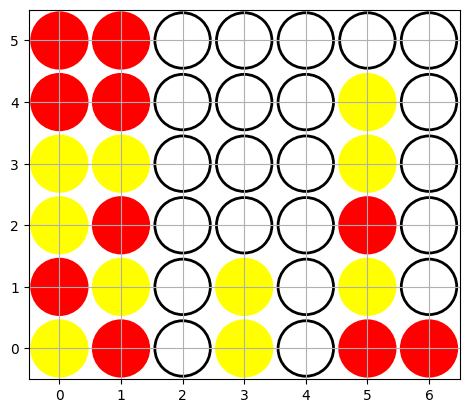

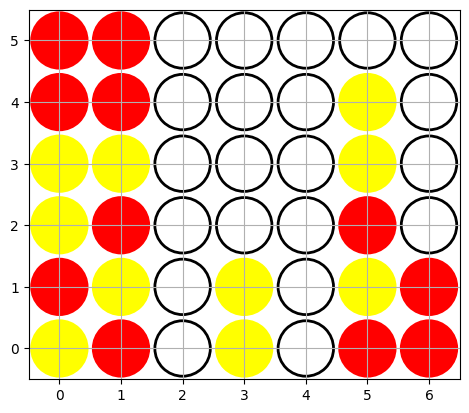

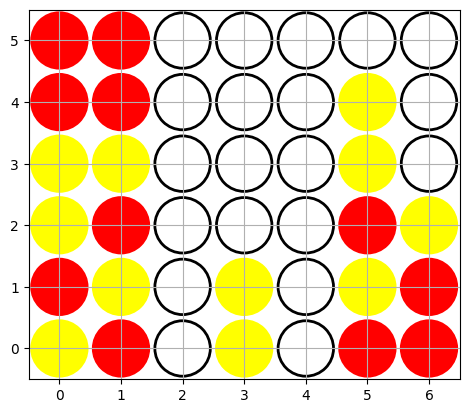

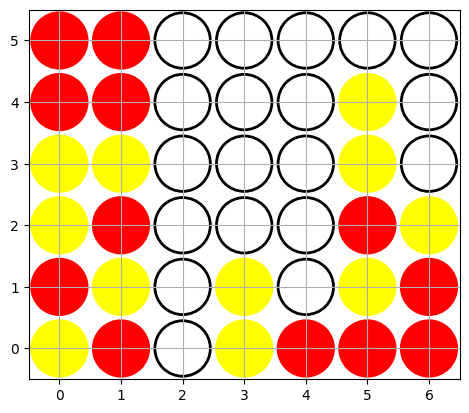

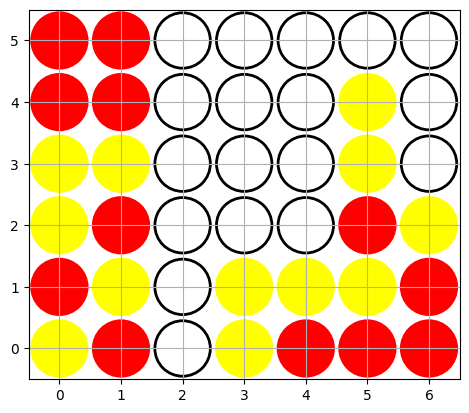

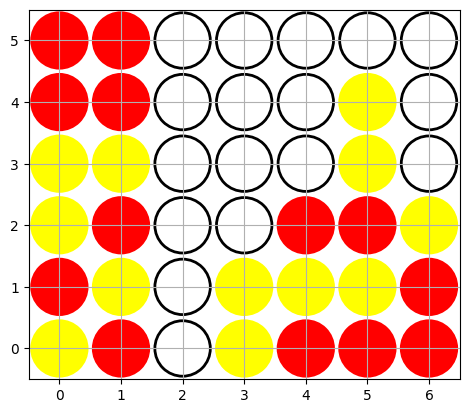

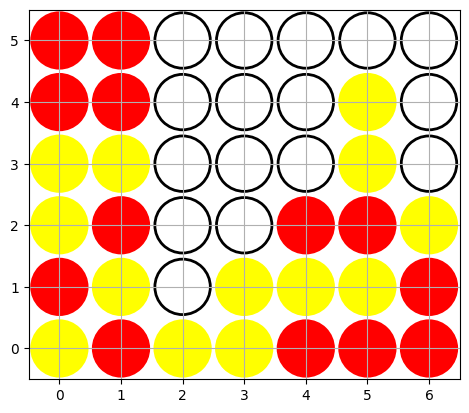

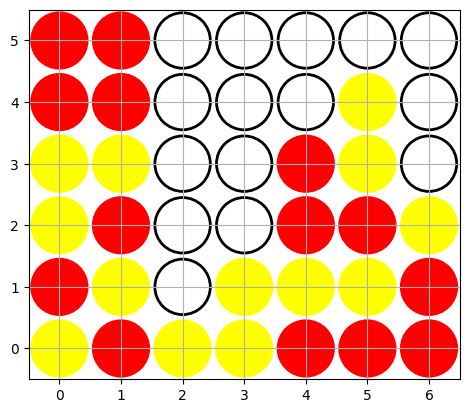

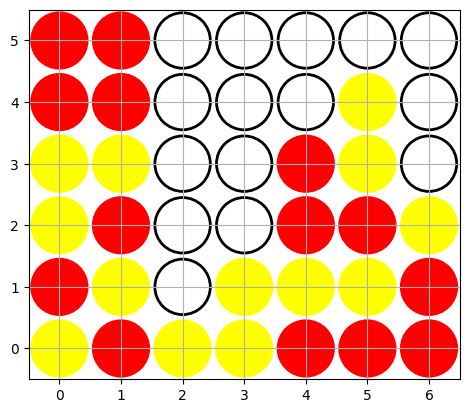

({1: 1, 2: 0}, 28.0)

In [81]:
env.play(agent, agent, n_games=1, show_game=True, show_outcome=True)
# env.play(agent, agent, n_games=100)

In [56]:
class HumanAgent(Agent):
    def __init__(self, env):
        self.env = env

    def choose_action(self):
        action = int(input("Enter your move: "))
        while action not in range(self.env.columns) or self.env.playable_rows[action] == -1:
            print("Invalid move. Try again.")
            action = int(input("Enter your move: "))
        return action

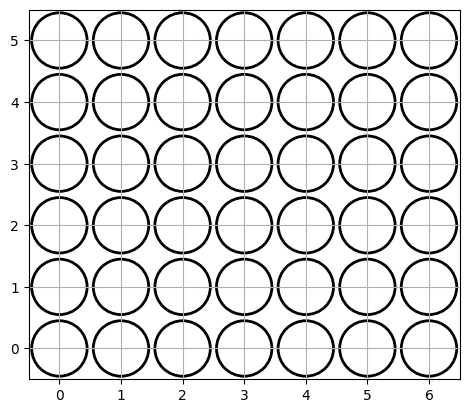

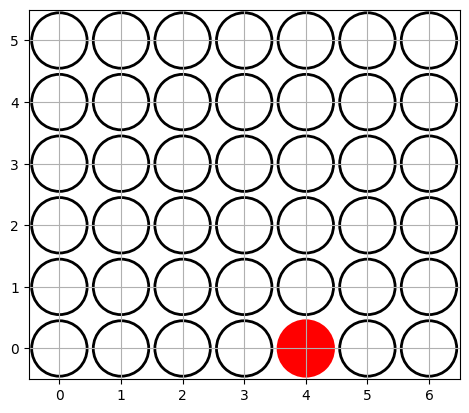

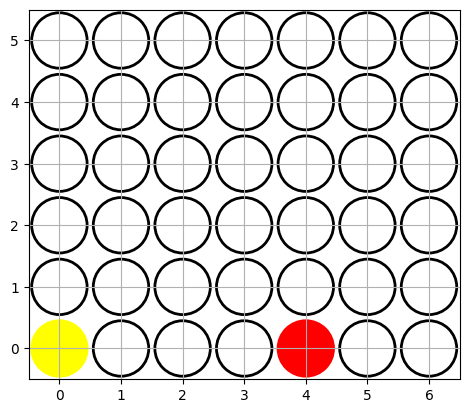

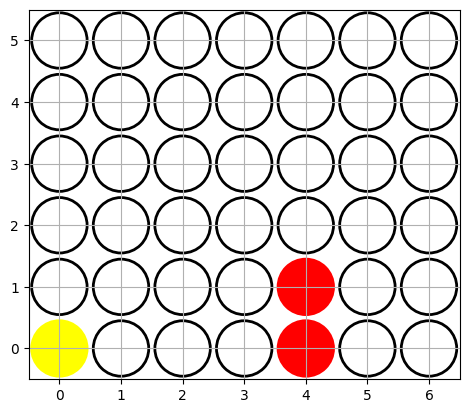

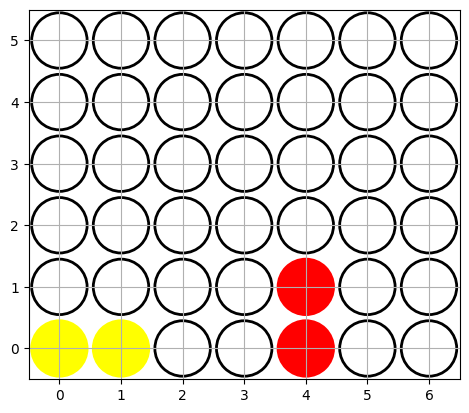

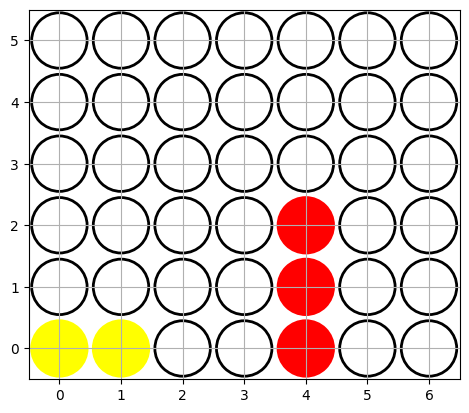

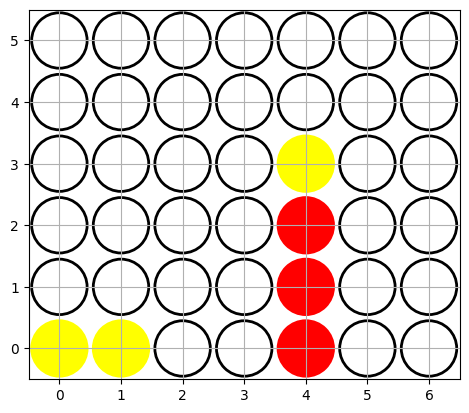

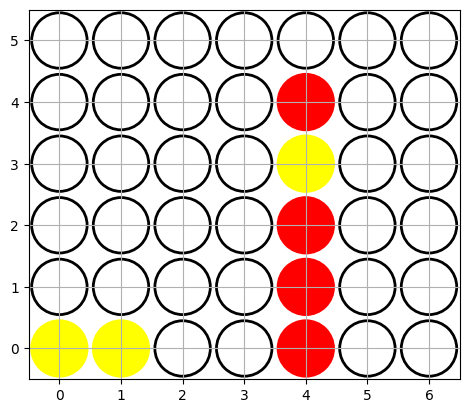

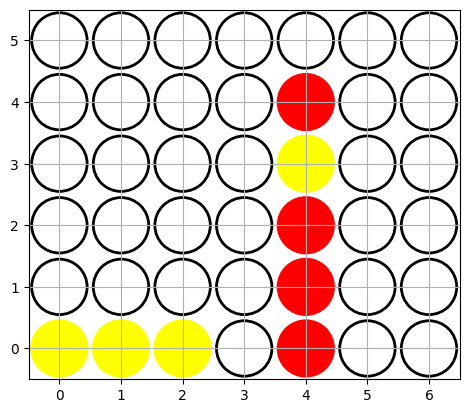

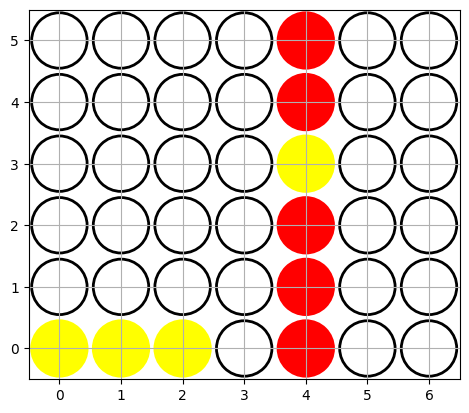

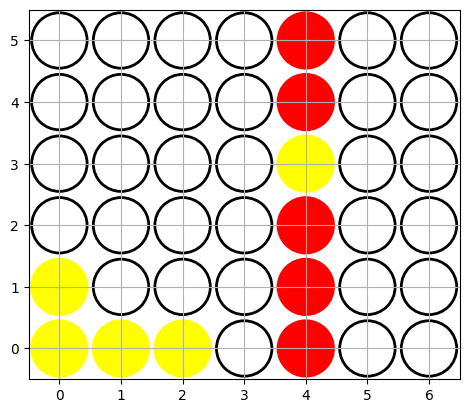

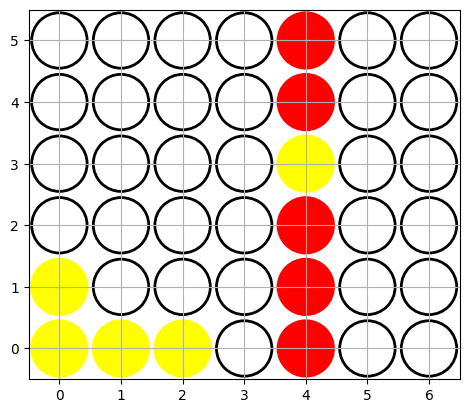

({1: 0, 2: 1}, 11.0)

In [59]:
# play against the trained model

env.play(agent, HumanAgent(env), n_games=1, show_game=True, show_outcome=True)

In [ ]:
# save the model
torch.save(agent.policy_net, 'connect_four_model.pt')

In [ ]:
# resume training

env = ConnectFourEnv()
replay_buffer = ReplayBuffer(10000)
agent = DQNAgent(env, replay_buffer)
agent.policy_net = torch.load('connect_four_model.pt')

In [ ]:
agent.evaluate(1000, message=True)

In [ ]:
# import profilers and check the training bottlenecks of the model

from torch.profiler import profile, record_function, ProfilerActivity


with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    agent.train(50, print_interval=100)

print(prof.key_averages().table(sort_by="self_cpu_time_total", row_limit=10))